In [1]:
!pip install tensorflow

In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

2025-06-22 16:27:34.757238: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-22 16:27:34.998442: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750609655.089272    1807 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750609655.114028    1807 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750609655.307939    1807 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [7]:
# Path to your single dataset folder (should have subfolders for each class)
data_dir = '/teamspace/studios/this_studio/anis/hibiscusDataSet'

# Parameters
BATCH_SIZE = 32
IMG_SIZE = (224, 224)  # DenseNet121 default input size
NUM_CLASSES = 8
EPOCHS = 10
VAL_SPLIT = 0.2  # 20% for validation
TEST_SPLIT = 0.1  # 10% for testing

In [8]:
# Step 2: Load and preprocess dataset with progress bar
def load_dataset(data_dir):
    images = []
    labels = []

    for class_idx, class_name in enumerate(CLASS_NAMES):
        class_dir = os.path.join(data_dir, class_name)
        if not os.path.exists(class_dir):
            print(f"Warning: Directory {class_dir} not found!")
            continue

        print(f"Loading {class_name} images...")
        for img_file in tqdm(os.listdir(class_dir)):
            img_path = os.path.join(class_dir, img_file)
            try:
                with Image.open(img_path) as img:
                    img = img.convert('RGB')  # Ensure RGB format
                    img = img.resize(IMAGE_SIZE)
                    img_array = np.array(img) / 255.0
                    if img_array.shape == (*IMAGE_SIZE, 3):
                        images.append(img_array)
                        labels.append(class_idx)
            except Exception as e:
                print(f"Error loading {img_path}: {e}")

    return np.array(images), np.array(labels)

In [9]:
pip install imbalanced-learn


Note: you may need to restart the kernel to use updated packages.


In [10]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from collections import Counter
import tensorflow as tf
import numpy as np
import os

# 🏷️ Get class names
class_names = sorted(os.listdir(data_dir))
NUM_CLASSES = len(class_names)
print("Classes:", class_names)

# 🖼️ Load file paths and labels
file_paths = []
labels = []

for class_idx, class_name in enumerate(class_names):
    class_dir = os.path.join(data_dir, class_name)
    for img_name in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_name)
        file_paths.append(img_path)
        labels.append(class_idx)

file_paths = np.array(file_paths)
labels = np.array(labels)

# 🧼 Load and preprocess images
X_images = []
for img_path in file_paths:
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    X_images.append(img.numpy())

X_images = np.array(X_images)
y = labels

# 🔀 Split data: 15% test first
X_temp, X_test, y_temp, y_test = train_test_split(
    X_images, y, 
    test_size=0.15, 
    random_state=42, 
    stratify=y
)

# 🔀 Now split X_temp into 82.35% train and 17.65% val to make them 70% and 15% of original
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, 
    test_size=0.1765,  # 15% of original = 15/85 ≈ 0.1765
    random_state=42, 
    stratify=y_temp
)

print(f"\nOriginal counts: {Counter(y)}")
print(f"Train: {len(X_train)} (before SMOTE), Val: {len(X_val)}, Test: {len(X_test)}")

# 🔁 Apply SMOTE
print("\nApplying SMOTE to training data...")
X_train_flat = X_train.reshape(X_train.shape[0], -1)
smote = SMOTE(random_state=42)
X_train_smote_flat, y_train_smote = smote.fit_resample(X_train_flat, y_train)
X_train_smote = X_train_smote_flat.reshape(-1, *X_train.shape[1:])

print(f"Before SMOTE: {X_train.shape[0]} samples")
print(f"After SMOTE: {X_train_smote.shape[0]} samples")
print("Class distribution after SMOTE:", Counter(y_train_smote))

# 📦 Create TF datasets
def create_dataset(X, y):
    return tf.data.Dataset.from_tensor_slices((X, tf.one_hot(y, depth=NUM_CLASSES)))

train_ds = create_dataset(X_train_smote, y_train_smote).shuffle(1000).batch(BATCH_SIZE)
val_ds = create_dataset(X_val, y_val).batch(BATCH_SIZE)
test_ds = create_dataset(X_test, y_test).batch(BATCH_SIZE)

print("\n✅ Dataset sizes:")
print(f"Training samples: {len(X_train_smote)}")
print(f"Validation samples: {len(X_val)}")
print(f"Test samples: {len(X_test)}")


Classes: ['Citruspot', 'Early_Mild_Spotting', 'Fungal_Infected', 'Healthy', 'Mild_Edge_Damage', 'Senescent', 'Slightly_Diseased', 'Wrinkled_Leaf']



Original counts: Counter({0: 1000, 1: 1000, 2: 1000, 3: 1000, 4: 1000, 5: 1000, 6: 1000, 7: 994})
Train: 5594 (before SMOTE), Val: 1200, Test: 1200

Applying SMOTE to training data...
Before SMOTE: 5594 samples
After SMOTE: 5600 samples
Class distribution after SMOTE: Counter({5: 700, 6: 700, 7: 700, 4: 700, 1: 700, 2: 700, 3: 700, 0: 700})

✅ Dataset sizes:
Training samples: 5600
Validation samples: 1200
Test samples: 1200


In [14]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# 🧩 Model settings
input_shape = (224, 224, 3)
NUM_CLASSES = 8  # Set your number of output classes

# ⚙️ Load InceptionV3 base model
base_model = InceptionV3(weights="imagenet", include_top=False, input_shape=input_shape)
base_model.trainable = True

# 🔨 Custom head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

# 🧠 Final model
model = Model(inputs=base_model.input, outputs=predictions)

# 🧪 Compile model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# 📋 Truncated model summary (first N layers only)
def print_truncated_model_summary(model, max_layers=15):
    print(f"{'='*65}")
    print(f"{'Layer (type)':<30} {'Output Shape':<20} {'Param #':<10}")
    print(f"{'='*65}")
    total_params = 0
    trainable_params = 0
    non_trainable_params = 0

    for i, layer in enumerate(model.layers[:max_layers]):
        output_shape = layer.output_shape if hasattr(layer, 'output_shape') else "N/A"
        params = layer.count_params()
        total_params += params
        if layer.trainable:
            trainable_params += params
        else:
            non_trainable_params += params
        print(f"{layer.name + ' (' + layer.__class__.__name__ + ')':<30} {str(output_shape):<20} {params:<10}")

    if len(model.layers) > max_layers:
        print("... (truncated)")

    print(f"{'='*65}")
    print(f"Total params: {total_params:,}")
    print(f"Trainable params: {trainable_params:,}")
    print(f"Non-trainable params: {non_trainable_params:,}")

print_truncated_model_summary(model)


Layer (type)                   Output Shape         Param #   
input_layer_3 (InputLayer)     N/A                  0         
conv2d_282 (Conv2D)            N/A                  864       
batch_normalization_282 (BatchNormalization) N/A                  96        
activation_282 (Activation)    N/A                  0         
conv2d_283 (Conv2D)            N/A                  9216      
batch_normalization_283 (BatchNormalization) N/A                  96        
activation_283 (Activation)    N/A                  0         
conv2d_284 (Conv2D)            N/A                  18432     
batch_normalization_284 (BatchNormalization) N/A                  192       
activation_284 (Activation)    N/A                  0         
max_pooling2d_12 (MaxPooling2D) N/A                  0         
conv2d_285 (Conv2D)            N/A                  5120      
batch_normalization_285 (BatchNormalization) N/A                  240       
activation_285 (Activation)    N/A                  0        

In [15]:
!pip install visualkeras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 36.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [visualkeras]


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


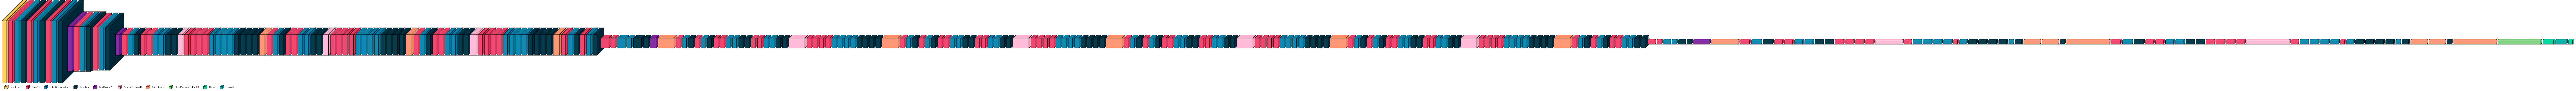

In [16]:
from visualkeras import layered_view

# Visualize the model
layered_view(model, legend=True, max_xy=300)

In [17]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# ✅ Define model name manually
model_name = "InceptionV3"

# ✅ Callbacks (using correct model name)
checkpoint = ModelCheckpoint(
    f"{model_name}.h5",
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-4
)

# ✅ Train
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[checkpoint, early_stop, reduce_lr]
)


Epoch 1/10


I0000 00:00:1750610506.902256    3619 service.cc:152] XLA service 0x7aec0c016d10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750610506.902861    3619 service.cc:160]   StreamExecutor device (0): NVIDIA L4, Compute Capability 8.9
2025-06-22 16:41:48.144259: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1750610514.265853    3619 cuda_dnn.cc:529] Loaded cuDNN version 90701
2025-06-22 16:41:59.027082: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_22807', 204 bytes spill stores, 204 bytes spill loads

2025-06-22 16:41:59.441075: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_22807_0', 396 by

  1/175 ━━━━━━━━━━━━━━━━━━━━ 4:08:26 86s/step - accuracy: 0.0312 - loss: 2.4004 - precision_3: 0.0000e+00 - recall_3: 0.0000e+00

I0000 00:00:1750610557.382782    3619 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.5354 - loss: 1.2575 - precision_3: 0.7578 - recall_3: 0.3421

2025-06-22 16:42:58.558632: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2487', 4 bytes spill stores, 4 bytes spill loads

2025-06-22 16:42:58.586259: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2487', 4 bytes spill stores, 4 bytes spill loads

2025-06-22 16:43:05.283476: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2480', 4 bytes spill stores, 4 bytes spill loads

2025-06-22 16:43:05.650156: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2480', 4 bytes spill stores, 4 bytes spill loads

2025-06-22 16:43:05.940759: I external/local_xla

175/175 ━━━━━━━━━━━━━━━━━━━━ 124s 219ms/step - accuracy: 0.5364 - loss: 1.2549 - precision_3: 0.7585 - recall_3: 0.3435 - val_accuracy: 0.8583 - val_loss: 0.4060 - val_precision_3: 0.8888 - val_recall_3: 0.8258 - learning_rate: 1.0000e-04
Epoch 2/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.9339 - loss: 0.2105 - precision_3: 0.9484 - recall_3: 0.9168

175/175 ━━━━━━━━━━━━━━━━━━━━ 20s 113ms/step - accuracy: 0.9340 - loss: 0.2103 - precision_3: 0.9484 - recall_3: 0.9169 - val_accuracy: 0.9275 - val_loss: 0.2232 - val_precision_3: 0.9419 - val_recall_3: 0.9192 - learning_rate: 1.0000e-04
Epoch 3/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 18s 103ms/step - accuracy: 0.9683 - loss: 0.0964 - precision_3: 0.9735 - recall_3: 0.9631 - val_accuracy: 0.9067 - val_loss: 0.3127 - val_precision_3: 0.9172 - val_recall_3: 0.9050 - learning_rate: 1.0000e-04
Epoch 4/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.9698 - loss: 0.1008 - precision_3: 0.9742 - recall_3: 0.9687

175/175 ━━━━━━━━━━━━━━━━━━━━ 19s 109ms/step - accuracy: 0.9699 - loss: 0.1007 - precision_3: 0.9742 - recall_3: 0.9687 - val_accuracy: 0.9342 - val_loss: 0.2432 - val_precision_3: 0.9466 - val_recall_3: 0.9308 - learning_rate: 1.0000e-04
Epoch 5/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.9745 - loss: 0.0815 - precision_3: 0.9776 - recall_3: 0.9709

175/175 ━━━━━━━━━━━━━━━━━━━━ 19s 110ms/step - accuracy: 0.9745 - loss: 0.0815 - precision_3: 0.9776 - recall_3: 0.9709 - val_accuracy: 0.9492 - val_loss: 0.1782 - val_precision_3: 0.9555 - val_recall_3: 0.9483 - learning_rate: 1.0000e-04
Epoch 6/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 18s 102ms/step - accuracy: 0.9849 - loss: 0.0435 - precision_3: 0.9875 - recall_3: 0.9836 - val_accuracy: 0.9125 - val_loss: 0.3621 - val_precision_3: 0.9162 - val_recall_3: 0.9108 - learning_rate: 1.0000e-04
Epoch 7/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 18s 102ms/step - accuracy: 0.9813 - loss: 0.0551 - precision_3: 0.9836 - recall_3: 0.9797 - val_accuracy: 0.9492 - val_loss: 0.1711 - val_precision_3: 0.9521 - val_recall_3: 0.9433 - learning_rate: 1.0000e-04
Epoch 8/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 18s 102ms/step - accuracy: 0.9867 - loss: 0.0439 - precision_3: 0.9879 - recall_3: 0.9862 - val_accuracy: 0.9275 - val_loss: 0.3105 - val_precision_3: 0.9335 - val_recall_3: 0.9242 - learning_rate: 1.0000e-04
Epoch 9/10
175/

175/175 ━━━━━━━━━━━━━━━━━━━━ 19s 109ms/step - accuracy: 0.9876 - loss: 0.0461 - precision_3: 0.9894 - recall_3: 0.9864 - val_accuracy: 0.9558 - val_loss: 0.1767 - val_precision_3: 0.9574 - val_recall_3: 0.9558 - learning_rate: 1.0000e-04
Epoch 10/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.9922 - loss: 0.0273 - precision_3: 0.9935 - recall_3: 0.9911

175/175 ━━━━━━━━━━━━━━━━━━━━ 19s 111ms/step - accuracy: 0.9922 - loss: 0.0272 - precision_3: 0.9935 - recall_3: 0.9911 - val_accuracy: 0.9742 - val_loss: 0.1026 - val_precision_3: 0.9741 - val_recall_3: 0.9725 - learning_rate: 1.0000e-04


In [18]:
pip install seaborn


Note: you may need to restart the kernel to use updated packages.


38/38 ━━━━━━━━━━━━━━━━━━━━ 15s 205ms/step
Classification Report:
                     precision    recall  f1-score   support

          Citruspot       1.00      0.97      0.99       150
Early_Mild_Spotting       0.99      0.95      0.97       150
    Fungal_Infected       0.97      0.99      0.98       150
            Healthy       0.97      0.99      0.98       150
   Mild_Edge_Damage       0.96      0.97      0.96       150
          Senescent       1.00      1.00      1.00       150
  Slightly_Diseased       0.95      0.98      0.96       150
      Wrinkled_Leaf       1.00      0.99      1.00       150

           accuracy                           0.98      1200
          macro avg       0.98      0.98      0.98      1200
       weighted avg       0.98      0.98      0.98      1200

Confusion matrix, without normalization


2025-06-22 16:46:27.287760: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


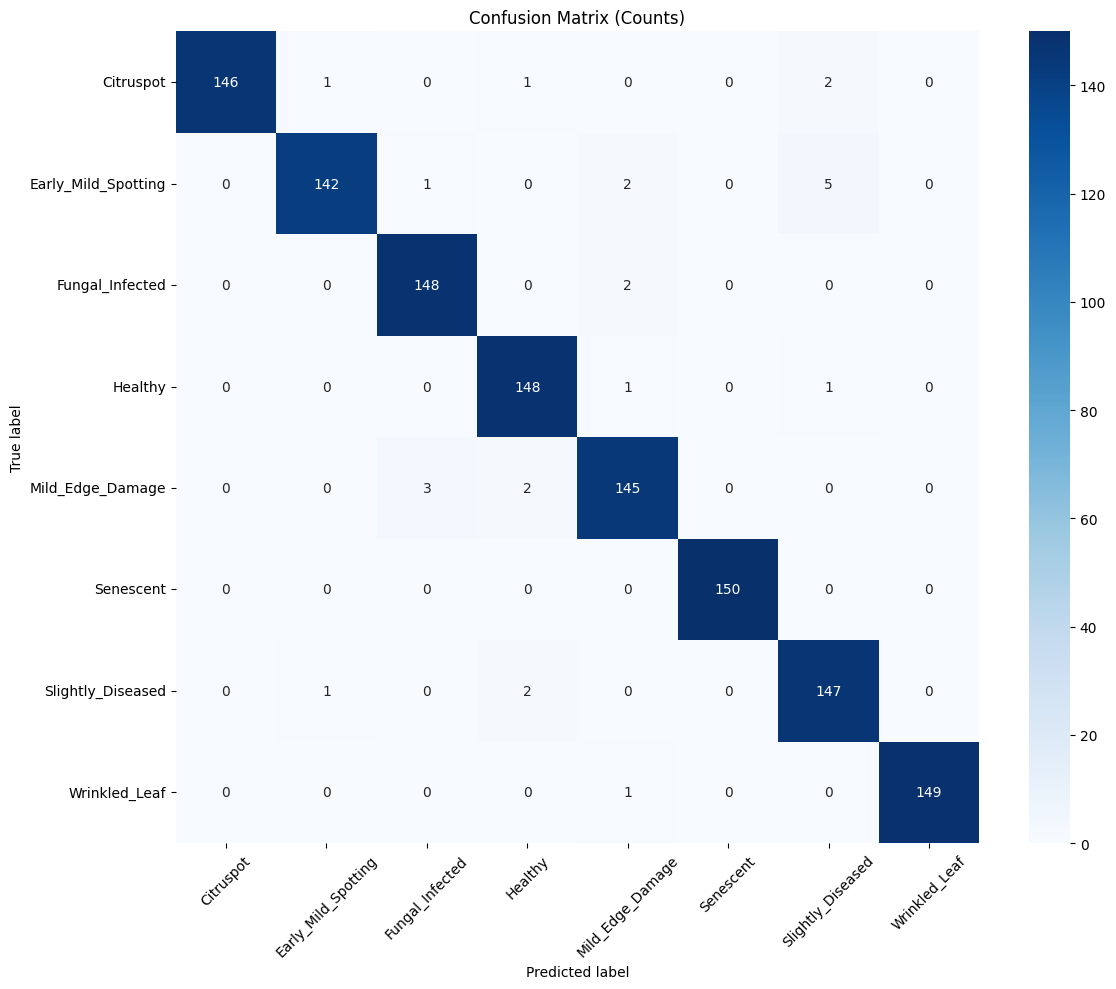

Normalized confusion matrix


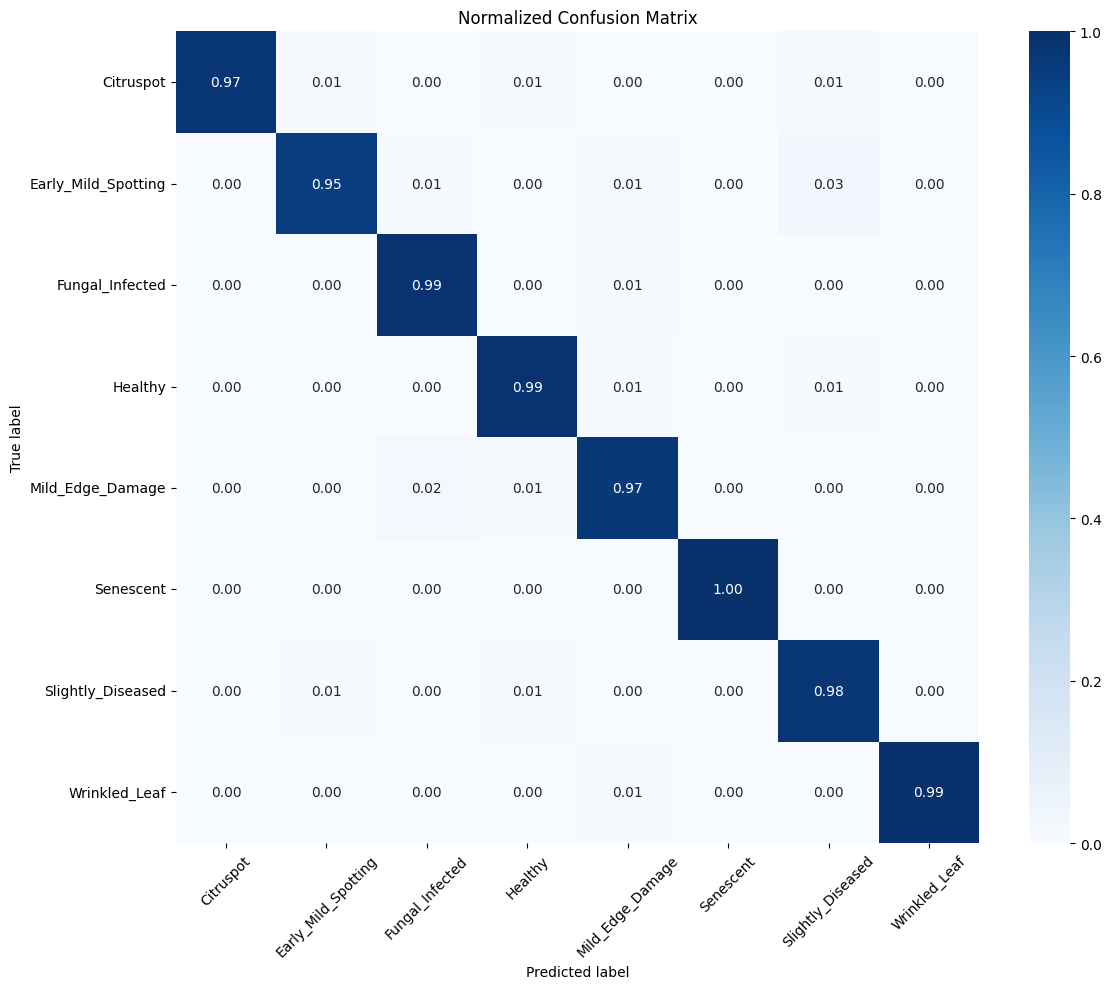

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# 1. Get predictions and true labels from test set
y_pred = model.predict(test_ds)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class indices
y_true = np.concatenate([np.argmax(y.numpy(), axis=1) for _, y in test_ds], axis=0)

# 2. Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))

# 3. Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    cm = confusion_matrix(y_true, y_pred)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='.2f' if normalize else 'd',
                cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_true, y_pred_classes, classes=class_names,
                      title='Confusion Matrix (Counts)')

# Plot normalized confusion matrix
plot_confusion_matrix(y_true, y_pred_classes, classes=class_names, normalize=True,
                      title='Normalized Confusion Matrix')

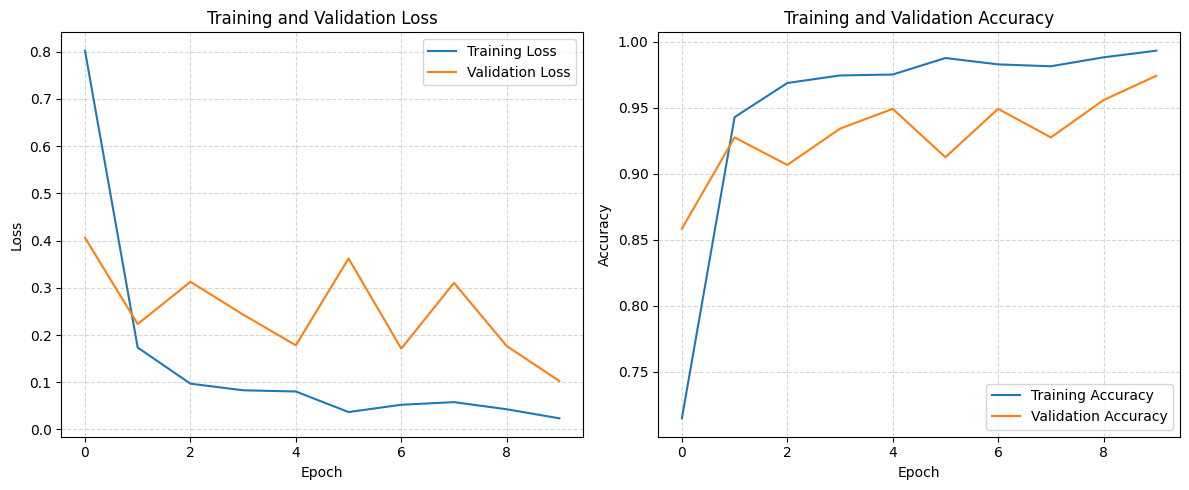


Best Validation Loss: 0.1026 at epoch 10
Corresponding Training Loss: 0.0236
Validation Accuracy at Best Epoch: 0.9742


In [20]:
import matplotlib.pyplot as plt

# Get training history from model.fit()
history = model.history.history

# Create figure with two subplots
plt.figure(figsize=(12, 5))

# 1. Plot Loss Curves
plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

# 2. Plot Accuracy Curves
plt.subplot(1, 2, 2)
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# Optional: Print best validation accuracy
best_val_epoch = np.argmin(history['val_loss'])
print(f"\nBest Validation Loss: {min(history['val_loss']):.4f} at epoch {best_val_epoch + 1}")
print(f"Corresponding Training Loss: {history['loss'][best_val_epoch]:.4f}")
print(f"Validation Accuracy at Best Epoch: {history['val_accuracy'][best_val_epoch]:.4f}")

13/38 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


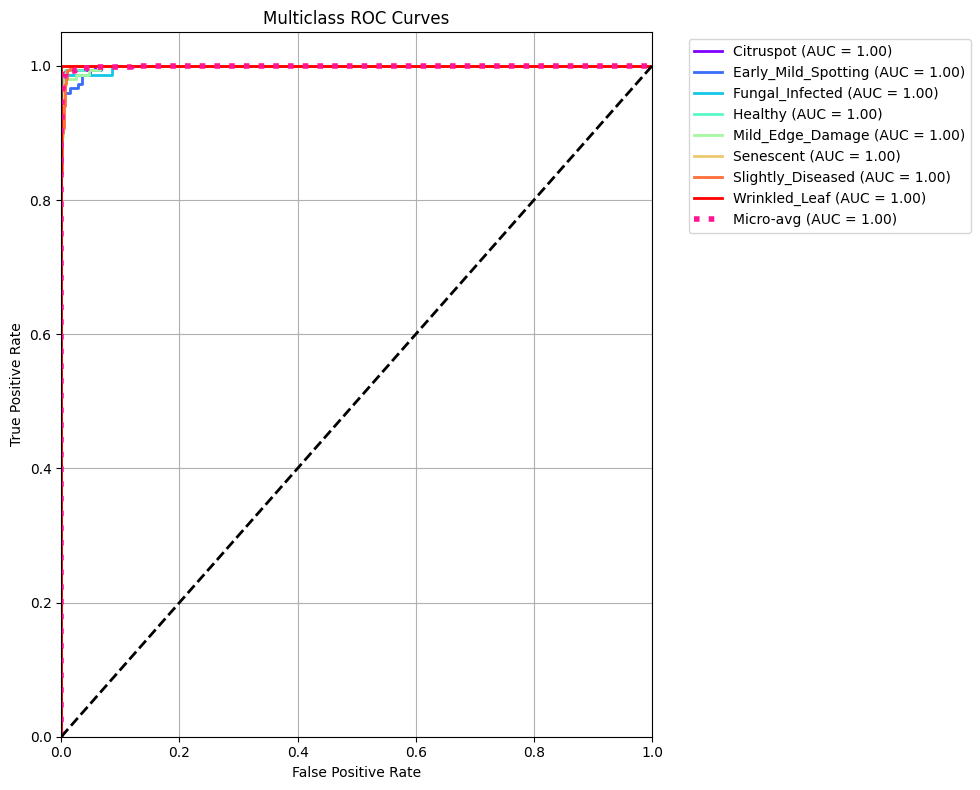


AUC Scores:
Citruspot: 0.9995
Early_Mild_Spotting: 0.9983
Fungal_Infected: 0.9987
Healthy: 0.9996
Mild_Edge_Damage: 0.9988
Senescent: 1.0000
Slightly_Diseased: 0.9993
Wrinkled_Leaf: 1.0000

Micro-average AUC: 0.9994


In [21]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle
import matplotlib.pyplot as plt
import numpy as np

# 1. Get predictions and true labels from test set
y_pred = model.predict(test_ds)
y_true = np.concatenate([y.numpy() for _, y in test_ds], axis=0)
y_true_labels = np.argmax(y_true, axis=1)  # Convert one-hot to labels

# 2. Binarize the true labels for multiclass ROC
y_true_bin = label_binarize(y_true_labels, classes=np.arange(NUM_CLASSES))

# 3. Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(NUM_CLASSES):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 4. Compute micro-average ROC curve and area
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# 5. Generate enough colors for all classes
colors = cycle(plt.cm.rainbow(np.linspace(0, 1, NUM_CLASSES)))

# 6. Plot ROC curves
plt.figure(figsize=(10, 8))
for i, color in zip(range(NUM_CLASSES), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='{0} (AUC = {1:0.2f})'.format(class_names[i], roc_auc[i]))

# Plot micro-average curve
plt.plot(fpr["micro"], tpr["micro"],
         label='Micro-avg (AUC = {0:0.2f})'.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

# Plot random guessing line
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curves')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# 7. Print AUC scores
print("\nAUC Scores:")
for i in range(NUM_CLASSES):
    print(f"{class_names[i]}: {roc_auc[i]:.4f}")
print(f"\nMicro-average AUC: {roc_auc['micro']:.4f}")

13/38 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


2025-06-22 16:47:24.396632: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


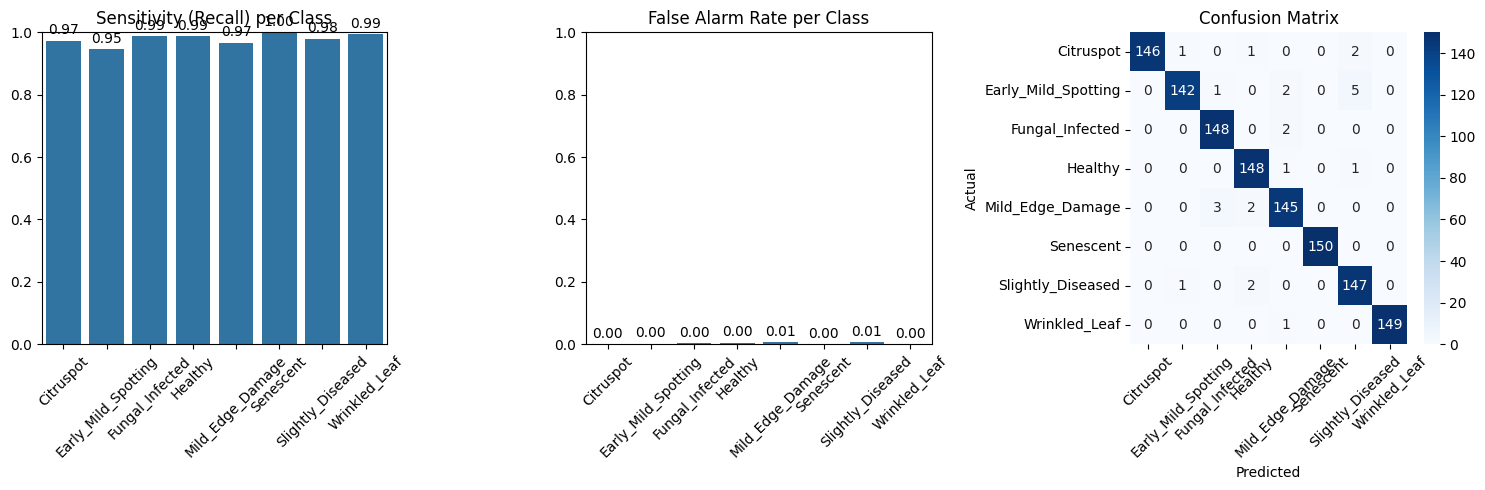


Class-wise Performance Metrics:
Class          Sensitivity    False Alarm Rate    
--------------------------------------------------
Citruspot      0.9733         0.0000              
Early_Mild_Spotting0.9467         0.0019              
Fungal_Infected0.9867         0.0038              
Healthy        0.9867         0.0048              
Mild_Edge_Damage0.9667         0.0057              
Senescent      1.0000         0.0000              
Slightly_Diseased0.9800         0.0076              
Wrinkled_Leaf  0.9933         0.0000              

Macro-average Sensitivity: 0.9792
Macro-average False Alarm Rate: 0.0030


In [22]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, recall_score

# 1. Get predictions and true labels
y_pred = model.predict(test_ds)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.concatenate([np.argmax(y.numpy(), axis=1) for _, y in test_ds], axis=0)

# 2. Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# 3. Calculate metrics for each class
sensitivity = []
false_alarm_rate = []
precision = []

for i in range(len(class_names)):
    # Sensitivity (Recall)
    sensitivity.append(recall_score(y_true, y_pred_classes, labels=[i], average=None)[0])
    
    # False Alarm Rate = FP / (FP + TN)
    fp = np.sum(cm[:, i]) - cm[i, i]
    tn = np.sum(cm) - np.sum(cm[i, :]) - np.sum(cm[:, i]) + cm[i, i]
    false_alarm_rate.append(fp / (fp + tn))


# 4. Create visualization
plt.figure(figsize=(15, 5))

# Sensitivity plot
plt.subplot(1, 3, 1)
sns.barplot(x=class_names, y=sensitivity)
plt.title('Sensitivity (Recall) per Class')
plt.ylim(0, 1)
plt.xticks(rotation=45)
for i, v in enumerate(sensitivity):
    plt.text(i, v+0.02, f"{v:.2f}", ha='center')

# False Alarm Rate plot
plt.subplot(1, 3, 2)
sns.barplot(x=class_names, y=false_alarm_rate)
plt.title('False Alarm Rate per Class')
plt.ylim(0, 1)
plt.xticks(rotation=45)
for i, v in enumerate(false_alarm_rate):
    plt.text(i, v+0.02, f"{v:.2f}", ha='center')

# Confusion Matrix
plt.subplot(1, 3, 3)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(rotation=45)
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()

# 5. Print metrics table
print("\nClass-wise Performance Metrics:")
print(f"{'Class':<15}{'Sensitivity':<15}{'False Alarm Rate':<20}")
print("-"*50)
for i in range(len(class_names)):
    print(f"{class_names[i]:<15}{sensitivity[i]:<15.4f}{false_alarm_rate[i]:<20.4f}")


# 6. Calculate macro averages
macro_sensitivity = np.mean(sensitivity)
macro_far = np.mean(false_alarm_rate)
print(f"\nMacro-average Sensitivity: {macro_sensitivity:.4f}")
print(f"Macro-average False Alarm Rate: {macro_far:.4f}")